In [1]:
#required imports
import tensorflow as tf
import pennylane as qml
from pennylane.qnodes import PassthruQNode
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [2]:
#using the simulated Pennylane device 'default.qubit.tf' in order to access state vector computed by qnode using PassthruQNode
dev = qml.device('default.qubit.tf', wires=4)

In [3]:
#defining 'one' layer of my circuit

def Layer(theta):
    #defining circuit U_i for i= odd
    qml.RZ(theta[0], wires= 0)
    qml.RZ(theta[1], wires= 1)
    qml.RZ(theta[2], wires= 2)
    qml.RZ(theta[3], wires= 3)
    qml.CZ(wires=[0,1])
    qml.CZ(wires=[0,2])
    qml.CZ(wires=[0,3])
    qml.CZ(wires=[1,2])
    qml.CZ(wires=[1,3])
    qml.CZ(wires=[2,3])
    
    #defining circuit U_i for i= even
    qml.RX(theta[4], wires= 0)
    qml.RX(theta[5], wires= 1)
    qml.RX(theta[6], wires= 2)
    qml.RX(theta[7], wires= 3)


In [4]:
#defining my quantum circuit
def circuit(theta):
  n= theta.get_shape().as_list()[0]  
  l= int(n/8)                                  # Here l is the no. of layers in our circuit, which is obtained by dividing total no. of parameters by no. of theta params in each layer(=8)
  for i in range(l):
    j=i*8
    Layer(theta[j:j+8])
  return qml.expval(qml.PauliZ(0))

In [5]:
# using a special feature of Pennylane in order to read/print the state vector computed by our quantum circuit
qnode = PassthruQNode(circuit, dev)           

The following function 


```
def find_min_distance(L, Phi)```



1.   Takes input parameters- L (number of layers in our quantum circuit) and previously initialized random state-vector $|\Phi\rangle$,

2.   initializes random theta parameters(trainable) tensor of size based on the input parameter L (Total number of params= no. of trainable params in one layer* L),

3.   optimizes the params($\theta_{i,n} \in \left(0,2 \pi\right)$) to minimize the distance $\epsilon$ between the computed state vector $|\Psi(\theta)\rangle$ and $|\Phi\rangle$ given by $\epsilon= min_{\theta}||\left(|\Psi(\theta)\rangle - |\Phi\rangle\right)||$, and

4.   returns the scalar minimum distance $\epsilon$ corresponding to the optimized theta params.   



 
##### **Optimization steps**
I define my number of optimization steps as a function of L(total number of layers). Large L corresponds to a more complex circuit, and qnode takes relatively more time to compute the cost function. But, minimization of cost function for large L is very quick. So I adjust the no. of steps with an inverse factor of L such that the computation time of the entire function for each L remains nearly same.

In [6]:
def find_min_distance(L, Phi):
  opt = tf.keras.optimizers.Adam(learning_rate=0.01)                            #using tf optimizer Adam with learning rate= 0.01
  steps = int(1000/L)                                                           #defining no. of steps as a function of L, large L requires less steps to converge with the same learning rate.
  theta= tf.Variable(np.random.uniform(0, 2*np.pi, 8*L))
  for i in range(steps):
    with tf.GradientTape() as tape:
      tape.watch(theta)
      qnode(theta)
      Psi=dev._state
      Psi= tf.reshape(Psi, [16])
      loss = tf.norm(Psi-Phi)                                                   # our cost function is the norm distance between Psi and Phi, which we want to minimize
    gradients = tape.gradient(loss, theta)
    opt.apply_gradients(zip([gradients], [theta]))
    min_dist= tf.get_static_value(loss)
  return min_dist

In [7]:
def min_dist_vs_L(L_max, Phi):                                                  # This function computes the minimum distance function for L = 1 to L= L_max and returns a numpy array of the computed min. dist values
  min_dist=L_max*[0]
  for i in range(L_max):
    print("Computing min. distance for L={:d}...".format(i+1))
    min_dist[i]= find_min_distance(i+1, Phi)
    print("done")
  return min_dist

Computing min. distance for L=1...
done
Computing min. distance for L=2...
done
Computing min. distance for L=3...
done
Computing min. distance for L=4...
done
Computing min. distance for L=5...
done
Computing min. distance for L=6...
done
Computing min. distance for L=7...
done
Computing min. distance for L=8...
done
Computing min. distance for L=9...
done
Computing min. distance for L=10...
done


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


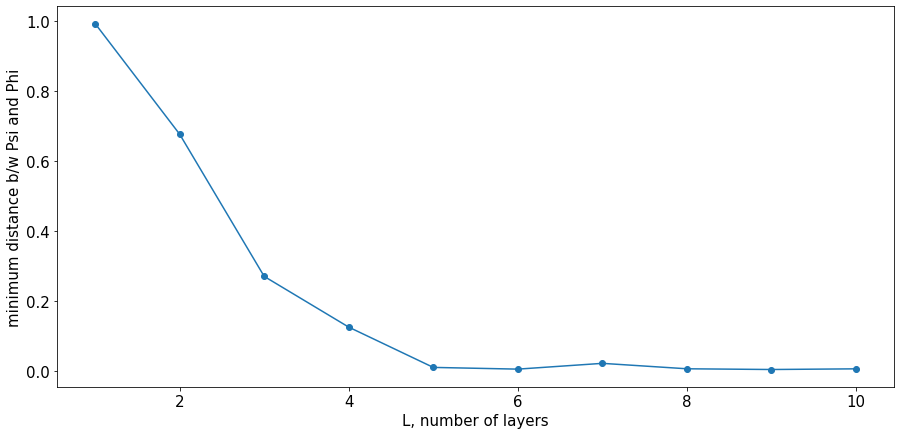

In [8]:
L_max= 10
L= range(1, L_max+1)

# defining our random 4-qubit normalized state vector here for once which will be used throughout in our computation
Phi= tf.Variable(np.random.random(16) + np.random.random(16) * 1j)
Phi= Phi/tf.norm(Phi)

epsilon= min_dist_vs_L(L_max, Phi)
plt.figure(figsize=(15,7))
plt.plot(L, epsilon,'-o')
plt.ylabel('minimum distance b/w Psi and Phi', fontsize=15)
plt.xlabel('L, number of layers', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

## Observations and conclusions



1.   The minimum distance between the computed state vector $|\Psi(\theta)\rangle$ and $|\Phi\rangle$ given by $\epsilon= min_{\theta}||\left(|\Psi(\theta)\rangle - |\Phi\rangle\right)||$ decreases with increasing L and converges to near zero. 

2.   For L>5, the increase in number of layers is redundant.

3.   The distance measure converging to zero implies the closeness(physical behaviour) of our state vector $|\Psi(\theta)\rangle$ to a desired state $|\Phi\rangle$ of our choice. So, the implementation of the above quantum circuit can be used to solve a quantum state-preparation problem wherein we'd be able to determine the right set of parametrized gates(optimal $\theta_{i,n}$ values) that need to be used in our quantum circuit to realize a quantum state of our choice(or a state with properties of our choice). 

